#### The following analysis explores the relationship between the plot keywords between the following set of movie
1. IMBD top 250
2. Top 250 highest grossing movies
3. Top 250 movies with the highest budget

#### The aim is to see what kind of movies are liked by the audience, critics and producers and whether or not there is an overlap

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('data/movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [4]:
df = df[df['num_voted_users'] > 100][['plot_keywords', 'gross', 'budget','duration','imdb_score', 'movie_title']]
# Split the plot_keyword string based on '|' and add an row for each string that is returned
tags = df['plot_keywords'].copy().str.split('|').apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.index
tags.name = 'tags'
df = df.join(tags)
df.head()

,plot_keywords,gross,budget,duration,imdb_score,movie_title,tags
0,avatar|future|marine|native|paraplegic,760505847.0,237000000.0,178.0,7.9,Avatar,avatar
0,avatar|future|marine|native|paraplegic,760505847.0,237000000.0,178.0,7.9,Avatar,future
0,avatar|future|marine|native|paraplegic,760505847.0,237000000.0,178.0,7.9,Avatar,marine
0,avatar|future|marine|native|paraplegic,760505847.0,237000000.0,178.0,7.9,Avatar,native
0,avatar|future|marine|native|paraplegic,760505847.0,237000000.0,178.0,7.9,Avatar,paraplegic


In [5]:
count_vect = CountVectorizer(ngram_range=(1,2), stop_words ={'and', 'in', 'of', 'the', 'on','to', 'title','reference',\
                                                             'female','male','by'})
# Calculated only term frequency.
X_train_counts = count_vect.fit_transform(df.tags.dropna())
X_train_counts

<23933x11125 sparse matrix of type '<type 'numpy.int64'>'
	with 44851 stored elements in Compressed Sparse Row format>

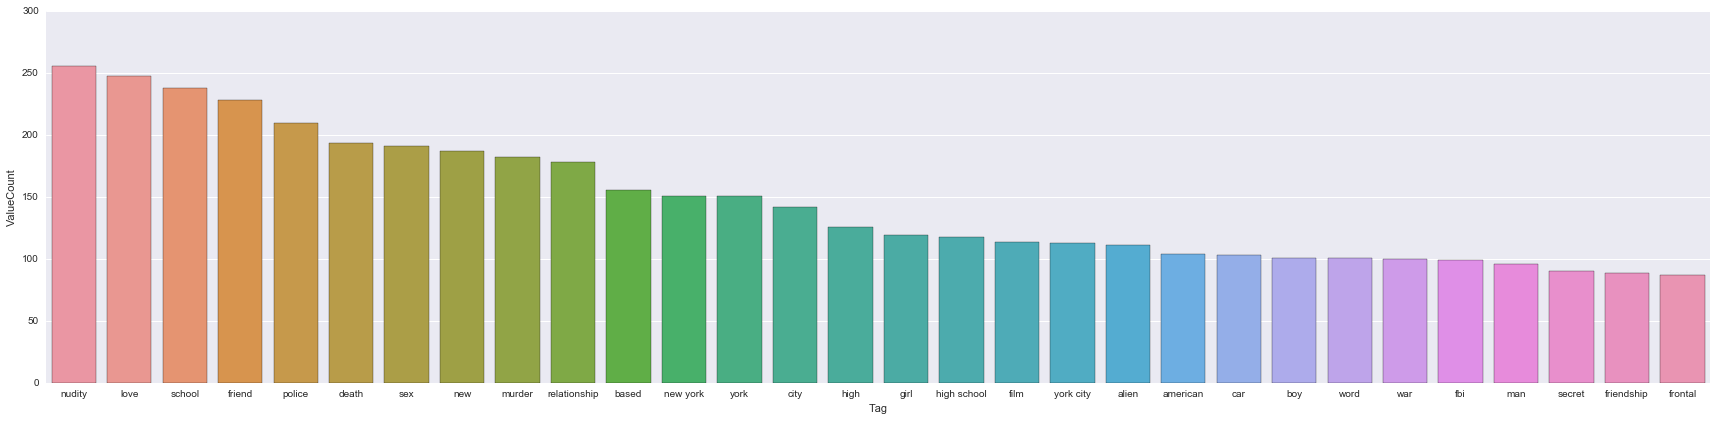

In [6]:
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
topValues = [x[1] for x in TopTags]
featurelist = count_vect.get_feature_names()
TopTagsNames = [featurelist[j] for j in ind]
TopTagsDf = pd.DataFrame({'Tag':TopTagsNames,'ValueCount':topValues})
ax = sns.factorplot(x="Tag", y="ValueCount", data = TopTagsDf, kind="bar", size=6, aspect=4)

In [7]:
# These are top 30 tags in all the plot keywords
TopTagsNames

[u'nudity',
 u'love',
 u'school',
 u'friend',
 u'police',
 u'death',
 u'sex',
 u'new',
 u'murder',
 u'relationship',
 u'based',
 u'new york',
 u'york',
 u'city',
 u'high',
 u'girl',
 u'high school',
 u'film',
 u'york city',
 u'alien',
 u'american',
 u'car',
 u'boy',
 u'word',
 u'war',
 u'fbi',
 u'man',
 u'secret',
 u'friendship',
 u'frontal']

In [8]:
Top250 = df[['movie_title','imdb_score']].drop_duplicates().sort_values('imdb_score').tail(250)
Top250IMDBScore = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250IMDBScore.tags.dropna())
X_train_counts

<1221x1559 sparse matrix of type '<type 'numpy.int64'>'
	with 2345 stored elements in Compressed Sparse Row format>

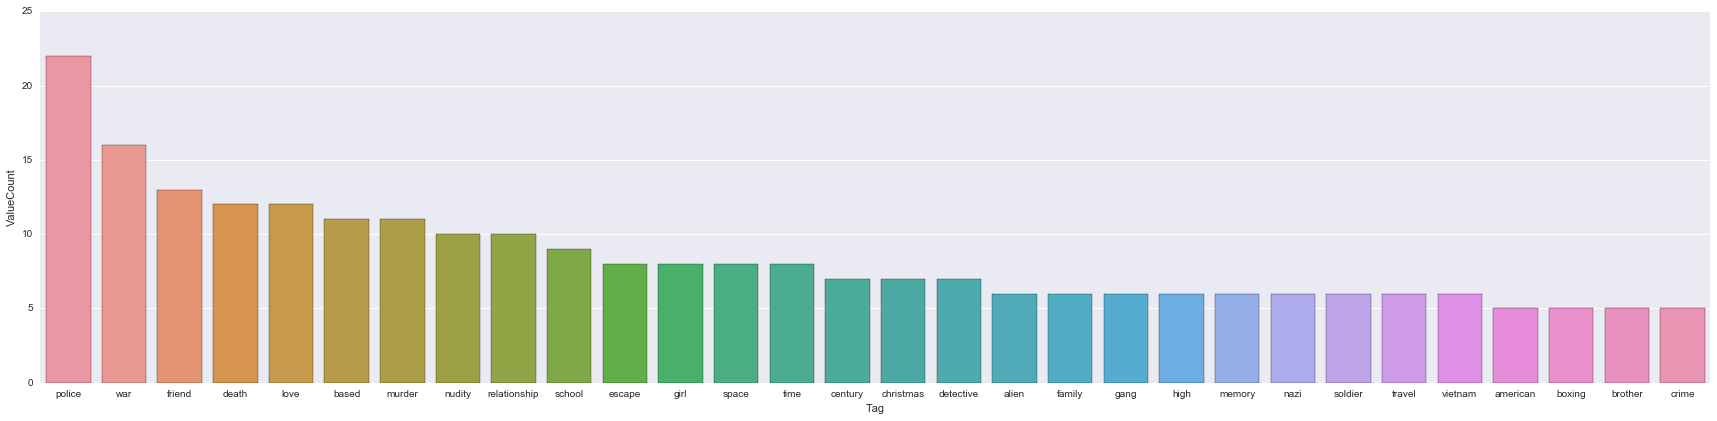

In [9]:
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValuesIMDB250 = [x[1] for x in TopTags]
TopTagsNamesIMDB250 = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNamesIMDB250,
                                                                  'ValueCount':topValuesIMDB250}),kind="bar",
                    size=6, aspect=4)


In [10]:
#Tag associated with the top 250 movies on IMDB
TopTagsNamesIMDB250

[u'police',
 u'war',
 u'friend',
 u'death',
 u'love',
 u'based',
 u'murder',
 u'nudity',
 u'relationship',
 u'school',
 u'escape',
 u'girl',
 u'space',
 u'time',
 u'century',
 u'christmas',
 u'detective',
 u'alien',
 u'family',
 u'gang',
 u'high',
 u'memory',
 u'nazi',
 u'soldier',
 u'travel',
 u'vietnam',
 u'american',
 u'boxing',
 u'brother',
 u'crime']

In [11]:
Top250 = df[['movie_title','gross']].drop_duplicates().sort_values('gross').tail(250)
Top250Grossing = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250Grossing.tags.dropna())
X_train_counts

<1009x1310 sparse matrix of type '<type 'numpy.int64'>'
	with 1985 stored elements in Compressed Sparse Row format>

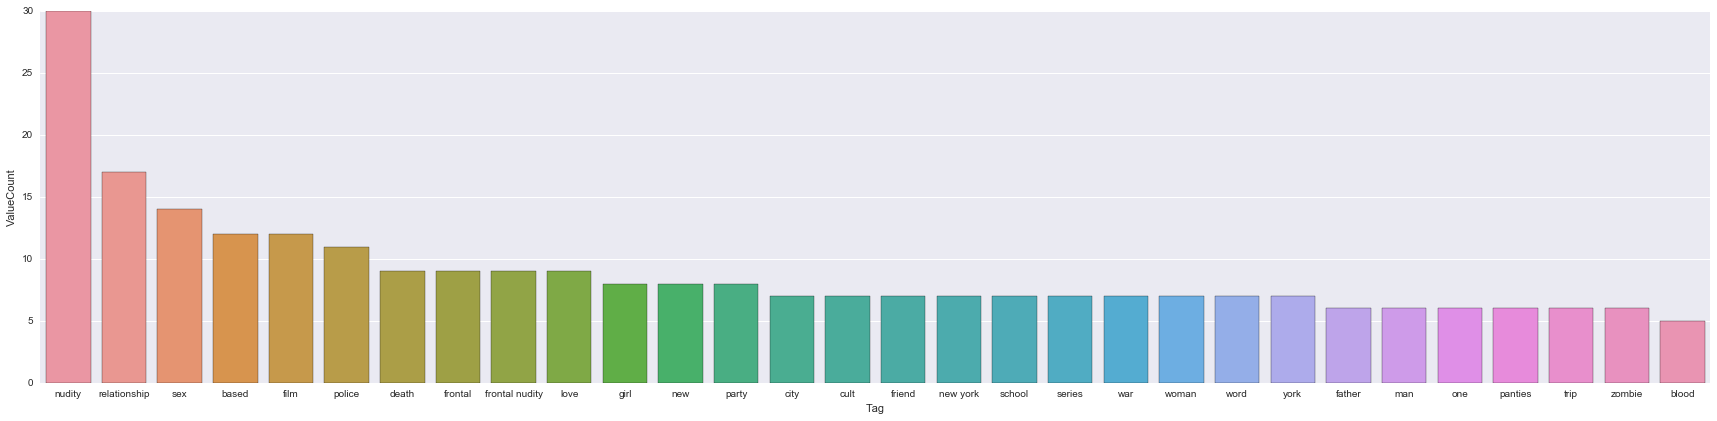

In [12]:
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValues250Grossing = [x[1] for x in TopTags]
TopTagsNames250Grossing = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNames250Grossing,
                                                                  'ValueCount':topValues250Grossing}),kind="bar",
                    size=6, aspect=4)

In [13]:
# Tags associated with the highest grossing movies
TopTagsNames250Grossing

[u'nudity',
 u'relationship',
 u'sex',
 u'based',
 u'film',
 u'police',
 u'death',
 u'frontal',
 u'frontal nudity',
 u'love',
 u'girl',
 u'new',
 u'party',
 u'city',
 u'cult',
 u'friend',
 u'new york',
 u'school',
 u'series',
 u'war',
 u'woman',
 u'word',
 u'york',
 u'father',
 u'man',
 u'one',
 u'panties',
 u'trip',
 u'zombie',
 u'blood']

In [14]:
Top250 = df[['movie_title','budget']].drop_duplicates().sort_values('budget').tail(250)
Top250Budget = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250Budget.tags.dropna())
X_train_counts

<1137x1420 sparse matrix of type '<type 'numpy.int64'>'
	with 2285 stored elements in Compressed Sparse Row format>

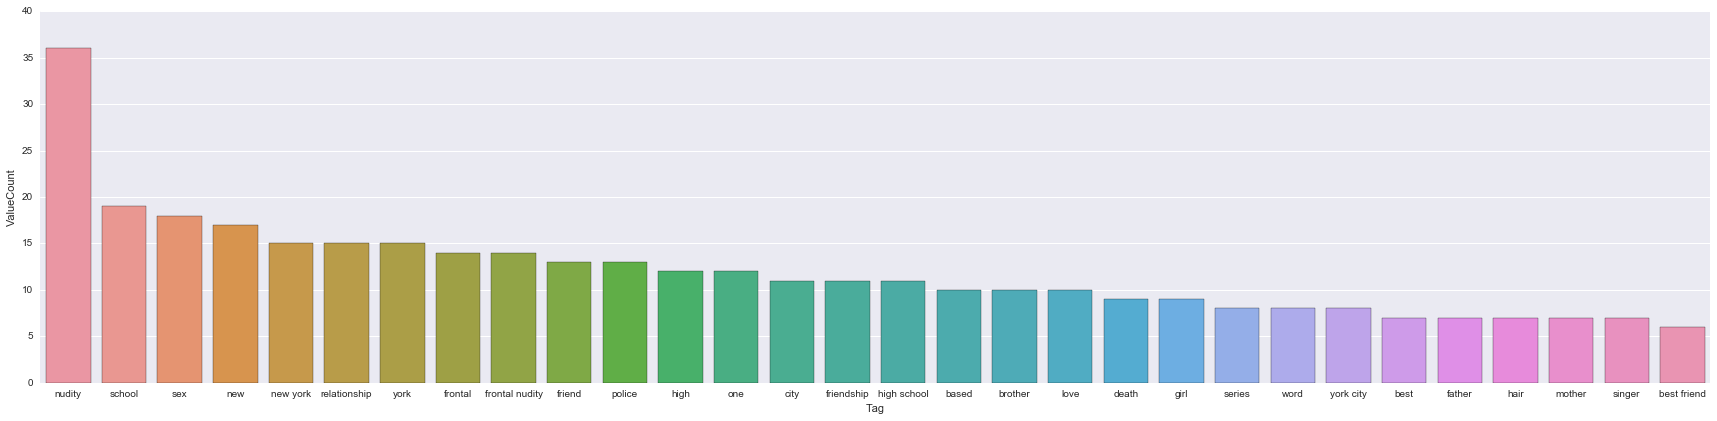

In [15]:
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValues250Budget = [x[1] for x in TopTags]
TopTagsNames250Budget = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNames250Budget,
                                                                  'ValueCount':topValues250Budget}),kind="bar",
                    size=6, aspect=4)

In [16]:
#Tags associated with the highest budgeted movies
TopTagsNames250Budget

[u'nudity',
 u'school',
 u'sex',
 u'new',
 u'new york',
 u'relationship',
 u'york',
 u'frontal',
 u'frontal nudity',
 u'friend',
 u'police',
 u'high',
 u'one',
 u'city',
 u'friendship',
 u'high school',
 u'based',
 u'brother',
 u'love',
 u'death',
 u'girl',
 u'series',
 u'word',
 u'york city',
 u'best',
 u'father',
 u'hair',
 u'mother',
 u'singer',
 u'best friend']

Nudity and sex seems to be a good selling point for blockbusters and the producers know it too as it is equally common in big budget movies. Apart from that New York is pretty popular in movies as it comes in all the lists except for the IMDB top 250. 

Finally people like to go to watch movies to which they can relate to that is why i guess sex, nudity and relationship are the top 3 keywords in the higest grossing movies and producers and cinema houses seems to know their audience as well. The highest rated films however are of a different class as they seem to tackle deeper and some times fictonal issue.

P.S. - I was not able find a way to properly represent the fact on graph, if you have an idea or method please leave a comment. 

In [34]:
commonTags = list(set(TopTagsNames250Budget).intersection(TopTagsNames250Grossing).intersection(TopTagsNamesIMDB250))

In [50]:
Top250Budget = pd.DataFrame({'Tag':TopTagsNames250Budget,'ValueCount':topValues250Budget})
Top250IMDB = pd.DataFrame({'Tag':TopTagsNamesIMDB250,'ValueCount':topValuesIMDB250})
Top250Gross = pd.DataFrame({'Tag':TopTagsNames250Grossing,'ValueCount':topValues250Grossing})

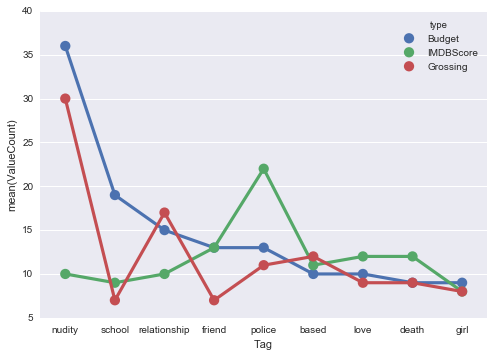

In [51]:
Top250BudgetFiltered = Top250Budget.copy()[Top250Budget['Tag'].isin(commonTags)]
Top250BudgetFiltered['type'] = 'Budget'
Top250IMDBFiltered = Top250IMDB.copy()[Top250IMDB['Tag'].isin(commonTags)]
Top250IMDBFiltered['type'] = 'IMDBScore'
Top250GrossFiltered = Top250Gross.copy()[Top250Gross['Tag'].isin(commonTags)]
Top250GrossFiltered['type'] = 'Grossing'
Top250BudgetFiltered = Top250BudgetFiltered.append(Top250IMDBFiltered).append(Top250GrossFiltered)
sns.pointplot(x="Tag", y="ValueCount", hue="type", data=Top250BudgetFiltered)